In [1]:
# Effort to reproduce results of
# https://www.biorxiv.org/content/10.1101/2020.01.08.898288v1.full#ref-21
# "Individual differences among deep neural network models"


# TODO: Get VGG753 working

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Dropout, GlobalAveragePooling2D,
                                    MaxPooling2D, Activation, Dense, Layer)
from tensorflow.keras.datasets import cifar10
from tensorflow.compat.v2.nn import local_response_normalization as lrn
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# num_validation_samples = 15000
# x_validation = x_train[:num_validation_samples].astype('float32')/255
# y_validation = y_train[:num_validation_samples]
# x_train = x_train[num_validation_samples:].astype('float32')/255
# y_train = y_train[num_validation_samples:]
# x_test = x_test.astype('float32')/255

num_validation_samples = 15000


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
# print(x_validation.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

num_classes = 10
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
#y_validation = to_categorical(y_validation, num_classes)
y_test = to_categorical(y_test, num_classes)

class LRN(Layer):
    def call(self, inp):
        return lrn(inp)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [1]:
# All_CNN_C architecture
def init_model(architecture: str, seed: int):
    
    if (architecture == 'all_cnn_c'):
        model = Sequential()
        #model.add(Dropout(0.2, input_shape=x_train.shape[1:])) #input shape from keras cifar10 example
        model.add(Conv2D(96, (3, 3), input_shape=x_train.shape[1:], padding='same',
                         kernel_regularizer=l2(1e-5), kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(96, (3, 3), padding='same', kernel_regularizer=l2(1e-5),
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(96, (3, 3), strides=2, padding='same',
                         kernel_regularizer=l2(1e-5), activation='relu'))
        #model.add(Dropout(0.5))
        model.add(Conv2D(192, (3, 3), padding='same', kernel_regularizer=l2(1e-5),
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(192, (3, 3), padding='same', kernel_regularizer=l2(1e-5),
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(192, (3, 3), strides=2, padding='same',kernel_regularizer=l2(1e-5),
                         kernel_initializer=he_normal(seed), activation='relu'))
        #model.add(Dropout(0.5))
        model.add(Conv2D(192, (3, 3), padding='valid', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(192, (1, 1), padding='valid', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(10, (1, 1), padding='valid', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        
        model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, clipnorm=500),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    elif (architecture =='vgg753'):
        model = Sequential()
        model.add(Conv2D(96, (7, 7), strides=2, input_shape=x_train.shape[1:], kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed)))
        # A little unsure about the order of these two
        model.add(LRN())
        model.add(Activation('relu'))
        ##
        model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
        model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
        model.add(Conv2D(1024, (3, 3), padding='same', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(Conv2D(1024, (3, 3), padding='same', kernel_regularizer=l2(1e-5), 
                         kernel_initializer=he_normal(seed), activation='relu'))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=0.01, epsilon=0.1, clipnorm=500),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    else:
        raise

    return model



In [22]:
test = init_model('all_cnn_c', seed=0)
test.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 192)       331968    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 192)         331968    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 6, 192)        

In [7]:
# Training

def train_primary():
    # only because interrupted after running for 0 and 1
    for i in range(2, 10):
        K.clear_session()
        all_cnn_c = init_model('all_cnn_c', seed=i)
        print('Training All_CNN_C with seed', str(i))
        a_history = all_cnn_c.fit(x_train, y_train,
                    batch_size=128,
                    epochs=350,
                    validation_data=(x_test, y_test),
                    shuffle=True)
        all_cnn_c.save('Primary/all_cnn_c_'+str(i)+'.h5')
        print('Training VGG-753 with seed', str(i))
        vgg753 = init_model('vgg753', seed=i)
        v_history = vgg753.fit(x_train, y_train,
                    batch_size=512,
                    epochs=250,
                    validation_data=(x_test, y_test),
                    shuffle=True)
        vgg753.save('Primary/vgg753_'+str(i)+'.h5')
    
        # Plots All_CNN_C
        acc = a_history.history['accuracy']
        val_acc = a_history.history['val_accuracy']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('All_CNN_C Training and validation accuracy at seed '+str(i))

        plt.legend()
        plt.figure()
        plt.show()
        
        # Plots VGG753
        acc = v_history.history['accuracy']
        val_acc = v_history.history['val_accuracy']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, 'bo', label='Training acc')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('VGG753 Training and validation accuracy at seed '+str(i))
        
        plt.legend()
        plt.figure()
        plt.show()

Training All_CNN_C with seed 2
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 13s 268us/sample - loss: 2.0378 - accuracy: 0.2555 - val_loss: 1.7282 - val_accuracy: 0.3489
Epoch 2/350
50000/50000 [==============================] - 10s 207us/sample - loss: 1.6127 - accuracy: 0.4088 - val_loss: 1.4727 - val_accuracy: 0.4657
Epoch 3/350
50000/50000 [==============================] - 10s 205us/sample - loss: 1.4455 - accuracy: 0.4818 - val_loss: 1.3111 - val_accuracy: 0.5313
Epoch 4/350
50000/50000 [==============================] - 10s 203us/sample - loss: 1.2965 - accuracy: 0.5411 - val_loss: 1.2010 - val_accuracy: 0.5742
Epoch 5/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.1735 - accuracy: 0.5903 - val_loss: 1.1429 - val_accuracy: 0.5919
Epoch 6/350
50000/50000 [==============================] - 10s 200us/sample - loss: 1.0532 - accuracy: 0.6351 - val_loss: 1.0997 - val_accuracy: 0.6191
Epoch 7

50000/50000 [==============================] - 10s 205us/sample - loss: 0.0375 - accuracy: 1.0000 - val_loss: 1.5518 - val_accuracy: 0.8027
Epoch 55/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0374 - accuracy: 1.0000 - val_loss: 1.5725 - val_accuracy: 0.8039
Epoch 56/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0374 - accuracy: 1.0000 - val_loss: 1.5852 - val_accuracy: 0.8039
Epoch 57/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0373 - accuracy: 1.0000 - val_loss: 1.5964 - val_accuracy: 0.8037
Epoch 58/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0372 - accuracy: 1.0000 - val_loss: 1.6041 - val_accuracy: 0.8040
Epoch 59/350
50000/50000 [==============================] - 10s 206us/sample - loss: 0.0372 - accuracy: 1.0000 - val_loss: 1.6106 - val_accuracy: 0.8045
Epoch 60/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0371 - a

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0319 - accuracy: 1.0000 - val_loss: 1.5284 - val_accuracy: 0.8060
Epoch 161/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0319 - accuracy: 1.0000 - val_loss: 1.5259 - val_accuracy: 0.8062
Epoch 162/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0318 - accuracy: 1.0000 - val_loss: 1.5254 - val_accuracy: 0.8061
Epoch 163/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0318 - accuracy: 1.0000 - val_loss: 1.5254 - val_accuracy: 0.8060
Epoch 164/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0317 - accuracy: 1.0000 - val_loss: 1.5249 - val_accuracy: 0.8060
Epoch 165/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0317 - accuracy: 1.0000 - val_loss: 1.5218 - val_accuracy: 0.8064
Epoch 166/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.03

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0274 - accuracy: 1.0000 - val_loss: 1.4997 - val_accuracy: 0.8055
Epoch 267/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0274 - accuracy: 1.0000 - val_loss: 1.4989 - val_accuracy: 0.8056
Epoch 268/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0273 - accuracy: 1.0000 - val_loss: 1.4985 - val_accuracy: 0.8053
Epoch 269/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0273 - accuracy: 1.0000 - val_loss: 1.4998 - val_accuracy: 0.8055
Epoch 270/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0273 - accuracy: 1.0000 - val_loss: 1.4993 - val_accuracy: 0.8058
Epoch 271/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0272 - accuracy: 1.0000 - val_loss: 1.5003 - val_accuracy: 0.8052
Epoch 272/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.02

50000/50000 [==============================] - 4s 89us/sample - loss: 0.8363 - accuracy: 0.7266 - val_loss: 1.0870 - val_accuracy: 0.6493
Epoch 23/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7937 - accuracy: 0.7413 - val_loss: 1.1533 - val_accuracy: 0.6366
Epoch 24/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7733 - accuracy: 0.7488 - val_loss: 1.0651 - val_accuracy: 0.6641
Epoch 25/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7241 - accuracy: 0.7634 - val_loss: 1.0895 - val_accuracy: 0.6656
Epoch 26/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6902 - accuracy: 0.7773 - val_loss: 1.1280 - val_accuracy: 0.6466
Epoch 27/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6522 - accuracy: 0.7923 - val_loss: 1.1416 - val_accuracy: 0.6612
Epoch 28/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.5946 - accuracy: 0.809

50000/50000 [==============================] - 5s 91us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3118 - val_accuracy: 0.6875
Epoch 131/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3117 - val_accuracy: 0.6878
Epoch 132/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3150 - val_accuracy: 0.6878
Epoch 133/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3160 - val_accuracy: 0.6878
Epoch 134/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3183 - val_accuracy: 0.6878
Epoch 135/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.3191 - val_accuracy: 0.6878
Epoch 136/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0722 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3584 - val_accuracy: 0.6872
Epoch 185/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3586 - val_accuracy: 0.6874
Epoch 186/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3590 - val_accuracy: 0.6871
Epoch 187/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3591 - val_accuracy: 0.6870
Epoch 188/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3593 - val_accuracy: 0.6870
Epoch 189/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.3598 - val_accuracy: 0.6871
Epoch 190/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3583 - val_accuracy: 0.6864
Epoch 239/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3578 - val_accuracy: 0.6861
Epoch 240/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3577 - val_accuracy: 0.6861
Epoch 241/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3571 - val_accuracy: 0.6865
Epoch 242/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3568 - val_accuracy: 0.6861
Epoch 243/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3571 - val_accuracy: 0.6867
Epoch 244/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.06

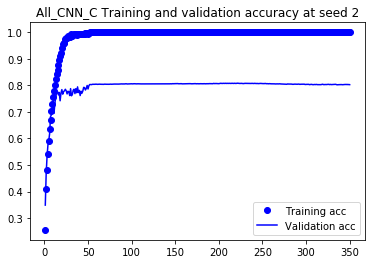

<Figure size 432x288 with 0 Axes>

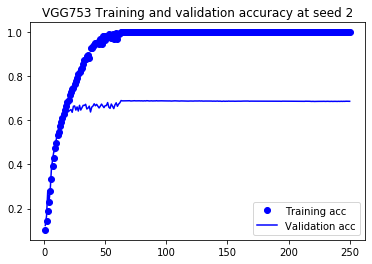

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 3
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 218us/sample - loss: 2.0865 - accuracy: 0.2368 - val_loss: 1.7211 - val_accuracy: 0.3706
Epoch 2/350
50000/50000 [==============================] - 10s 200us/sample - loss: 1.6344 - accuracy: 0.3959 - val_loss: 1.5836 - val_accuracy: 0.4320
Epoch 3/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.4332 - accuracy: 0.4844 - val_loss: 1.3394 - val_accuracy: 0.5202
Epoch 4/350
50000/50000 [==============================] - 10s 203us/sample - loss: 1.2722 - accuracy: 0.5497 - val_loss: 1.1564 - val_accuracy: 0.5964
Epoch 5/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.1375 - accuracy: 0.6022 - val_loss: 1.1067 - val_accuracy: 0.6029
Epoch 6/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.0381 - accuracy: 0.6390 - val_loss: 0.9822 - val_accuracy: 0.6612
Epoch 7

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0356 - accuracy: 1.0000 - val_loss: 1.5087 - val_accuracy: 0.8172
Epoch 55/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0355 - accuracy: 1.0000 - val_loss: 1.5109 - val_accuracy: 0.8167
Epoch 56/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0355 - accuracy: 1.0000 - val_loss: 1.5142 - val_accuracy: 0.8171
Epoch 57/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0354 - accuracy: 1.0000 - val_loss: 1.5154 - val_accuracy: 0.8169
Epoch 58/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0354 - accuracy: 1.0000 - val_loss: 1.5165 - val_accuracy: 0.8176
Epoch 59/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0353 - accuracy: 1.0000 - val_loss: 1.5173 - val_accuracy: 0.8170
Epoch 60/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0353 - a

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0304 - accuracy: 1.0000 - val_loss: 1.4662 - val_accuracy: 0.8189
Epoch 161/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0304 - accuracy: 1.0000 - val_loss: 1.4658 - val_accuracy: 0.8184
Epoch 162/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0303 - accuracy: 1.0000 - val_loss: 1.4664 - val_accuracy: 0.8189
Epoch 163/350
50000/50000 [==============================] - 10s 205us/sample - loss: 0.0303 - accuracy: 1.0000 - val_loss: 1.4646 - val_accuracy: 0.8186
Epoch 164/350
50000/50000 [==============================] - 10s 205us/sample - loss: 0.0303 - accuracy: 1.0000 - val_loss: 1.4647 - val_accuracy: 0.8195
Epoch 165/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0302 - accuracy: 1.0000 - val_loss: 1.4670 - val_accuracy: 0.8190
Epoch 166/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.03

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0262 - accuracy: 1.0000 - val_loss: 1.4765 - val_accuracy: 0.8168
Epoch 267/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0262 - accuracy: 1.0000 - val_loss: 1.4762 - val_accuracy: 0.8171
Epoch 268/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0262 - accuracy: 1.0000 - val_loss: 1.4759 - val_accuracy: 0.8174
Epoch 269/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0261 - accuracy: 1.0000 - val_loss: 1.4751 - val_accuracy: 0.8176
Epoch 270/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0261 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.8173
Epoch 271/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0261 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.8173
Epoch 272/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.02

50000/50000 [==============================] - 4s 89us/sample - loss: 0.8270 - accuracy: 0.7312 - val_loss: 1.0945 - val_accuracy: 0.6530
Epoch 23/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7949 - accuracy: 0.7430 - val_loss: 1.1122 - val_accuracy: 0.6439
Epoch 24/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7580 - accuracy: 0.7556 - val_loss: 1.0726 - val_accuracy: 0.6618
Epoch 25/250
50000/50000 [==============================] - 4s 88us/sample - loss: 0.7102 - accuracy: 0.7733 - val_loss: 1.1318 - val_accuracy: 0.6523
Epoch 26/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6627 - accuracy: 0.7897 - val_loss: 1.1084 - val_accuracy: 0.6572
Epoch 27/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6424 - accuracy: 0.7974 - val_loss: 1.1569 - val_accuracy: 0.6553
Epoch 28/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.5909 - accuracy: 0.815

50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2551 - val_accuracy: 0.6930
Epoch 131/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2565 - val_accuracy: 0.6928
Epoch 132/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2581 - val_accuracy: 0.6929
Epoch 133/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2605 - val_accuracy: 0.6927
Epoch 134/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2616 - val_accuracy: 0.6931
Epoch 135/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.2631 - val_accuracy: 0.6929
Epoch 136/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0720 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.3035 - val_accuracy: 0.6918
Epoch 185/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.3039 - val_accuracy: 0.6912
Epoch 186/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.3042 - val_accuracy: 0.6918
Epoch 187/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.3044 - val_accuracy: 0.6914
Epoch 188/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.3062 - val_accuracy: 0.6912
Epoch 189/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.3049 - val_accuracy: 0.6920
Epoch 190/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.3084 - val_accuracy: 0.6922
Epoch 239/250
50000/50000 [==============================] - 4s 88us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.3072 - val_accuracy: 0.6928
Epoch 240/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.3087 - val_accuracy: 0.6927
Epoch 241/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.3076 - val_accuracy: 0.6919
Epoch 242/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.3070 - val_accuracy: 0.6929
Epoch 243/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.3074 - val_accuracy: 0.6931
Epoch 244/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.06

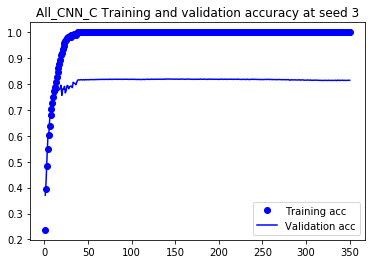

<Figure size 432x288 with 0 Axes>

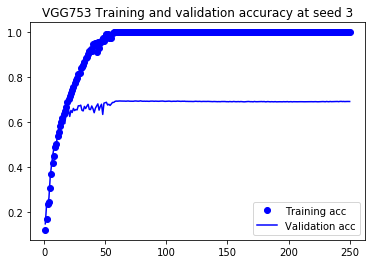

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 4
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 215us/sample - loss: 2.1609 - accuracy: 0.2163 - val_loss: 1.9437 - val_accuracy: 0.3215
Epoch 2/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.6861 - accuracy: 0.3821 - val_loss: 1.6046 - val_accuracy: 0.4165
Epoch 3/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.4725 - accuracy: 0.4671 - val_loss: 1.3896 - val_accuracy: 0.4986
Epoch 4/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.3366 - accuracy: 0.5230 - val_loss: 1.2109 - val_accuracy: 0.5731
Epoch 5/350
50000/50000 [==============================] - 10s 203us/sample - loss: 1.1974 - accuracy: 0.5810 - val_loss: 1.1827 - val_accuracy: 0.5874
Epoch 6/350
50000/50000 [==============================] - 10s 203us/sample - loss: 1.0757 - accuracy: 0.6256 - val_loss: 1.0463 - val_accuracy: 0.6344
Epoch 7

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0372 - accuracy: 1.0000 - val_loss: 1.4529 - val_accuracy: 0.8236
Epoch 55/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0371 - accuracy: 1.0000 - val_loss: 1.4605 - val_accuracy: 0.8229
Epoch 56/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0371 - accuracy: 1.0000 - val_loss: 1.4654 - val_accuracy: 0.8236
Epoch 57/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0370 - accuracy: 1.0000 - val_loss: 1.4708 - val_accuracy: 0.8232
Epoch 58/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0369 - accuracy: 1.0000 - val_loss: 1.4746 - val_accuracy: 0.8237
Epoch 59/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0369 - accuracy: 1.0000 - val_loss: 1.4776 - val_accuracy: 0.8236
Epoch 60/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0368 - a

50000/50000 [==============================] - 10s 201us/sample - loss: 0.0317 - accuracy: 1.0000 - val_loss: 1.3966 - val_accuracy: 0.8232
Epoch 161/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0316 - accuracy: 1.0000 - val_loss: 1.3955 - val_accuracy: 0.8222
Epoch 162/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0316 - accuracy: 1.0000 - val_loss: 1.3949 - val_accuracy: 0.8232
Epoch 163/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0316 - accuracy: 1.0000 - val_loss: 1.3927 - val_accuracy: 0.8220
Epoch 164/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0315 - accuracy: 1.0000 - val_loss: 1.3938 - val_accuracy: 0.8222
Epoch 165/350
50000/50000 [==============================] - 10s 200us/sample - loss: 0.0315 - accuracy: 1.0000 - val_loss: 1.3935 - val_accuracy: 0.8225
Epoch 166/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.03

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0272 - accuracy: 1.0000 - val_loss: 1.3913 - val_accuracy: 0.8200
Epoch 267/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0272 - accuracy: 1.0000 - val_loss: 1.3913 - val_accuracy: 0.8207
Epoch 268/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0272 - accuracy: 1.0000 - val_loss: 1.3933 - val_accuracy: 0.8206
Epoch 269/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0271 - accuracy: 1.0000 - val_loss: 1.3913 - val_accuracy: 0.8205
Epoch 270/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0271 - accuracy: 1.0000 - val_loss: 1.3928 - val_accuracy: 0.8200
Epoch 271/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0271 - accuracy: 1.0000 - val_loss: 1.3926 - val_accuracy: 0.8199
Epoch 272/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.02

50000/50000 [==============================] - 4s 89us/sample - loss: 0.8385 - accuracy: 0.7236 - val_loss: 1.2029 - val_accuracy: 0.6220
Epoch 23/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.8051 - accuracy: 0.7378 - val_loss: 1.1105 - val_accuracy: 0.6416
Epoch 24/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7438 - accuracy: 0.7614 - val_loss: 1.1049 - val_accuracy: 0.6595
Epoch 25/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6918 - accuracy: 0.7787 - val_loss: 1.0855 - val_accuracy: 0.6679
Epoch 26/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6760 - accuracy: 0.7852 - val_loss: 1.1624 - val_accuracy: 0.6510
Epoch 27/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6257 - accuracy: 0.8015 - val_loss: 1.1231 - val_accuracy: 0.6627
Epoch 28/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.5893 - accuracy: 0.816

50000/50000 [==============================] - 4s 89us/sample - loss: 0.0725 - accuracy: 1.0000 - val_loss: 3.3271 - val_accuracy: 0.6873
Epoch 131/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0725 - accuracy: 1.0000 - val_loss: 3.3284 - val_accuracy: 0.6876
Epoch 132/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3293 - val_accuracy: 0.6877
Epoch 133/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3312 - val_accuracy: 0.6881
Epoch 134/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3324 - val_accuracy: 0.6884
Epoch 135/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3337 - val_accuracy: 0.6883
Epoch 136/250
50000/50000 [==============================] - 4s 88us/sample - loss: 0.0723 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0710 - accuracy: 1.0000 - val_loss: 3.3663 - val_accuracy: 0.6872
Epoch 185/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0710 - accuracy: 1.0000 - val_loss: 3.3662 - val_accuracy: 0.6869
Epoch 186/250
50000/50000 [==============================] - 4s 88us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3672 - val_accuracy: 0.6877
Epoch 187/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3666 - val_accuracy: 0.6875
Epoch 188/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3665 - val_accuracy: 0.6867
Epoch 189/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3665 - val_accuracy: 0.6869
Epoch 190/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0695 - accuracy: 1.0000 - val_loss: 3.3598 - val_accuracy: 0.6865
Epoch 239/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0695 - accuracy: 1.0000 - val_loss: 3.3590 - val_accuracy: 0.6867
Epoch 240/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0695 - accuracy: 1.0000 - val_loss: 3.3587 - val_accuracy: 0.6865
Epoch 241/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3588 - val_accuracy: 0.6866
Epoch 242/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3580 - val_accuracy: 0.6864
Epoch 243/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3585 - val_accuracy: 0.6859
Epoch 244/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.06

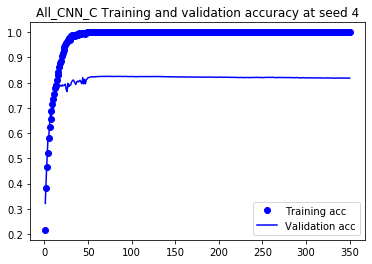

<Figure size 432x288 with 0 Axes>

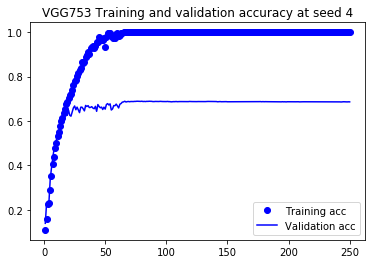

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 5
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 221us/sample - loss: 2.0200 - accuracy: 0.2459 - val_loss: 1.7775 - val_accuracy: 0.3339
Epoch 2/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.6120 - accuracy: 0.4098 - val_loss: 1.5142 - val_accuracy: 0.4422
Epoch 3/350
50000/50000 [==============================] - 10s 200us/sample - loss: 1.4207 - accuracy: 0.4860 - val_loss: 1.3503 - val_accuracy: 0.5183
Epoch 4/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.2620 - accuracy: 0.5496 - val_loss: 1.2917 - val_accuracy: 0.5469
Epoch 5/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.1467 - accuracy: 0.5964 - val_loss: 1.0970 - val_accuracy: 0.6134
Epoch 6/350
50000/50000 [==============================] - 10s 203us/sample - loss: 1.0474 - accuracy: 0.6343 - val_loss: 1.0449 - val_accuracy: 0.6322
Epoch 7

50000/50000 [==============================] - 10s 201us/sample - loss: 0.0359 - accuracy: 1.0000 - val_loss: 1.4095 - val_accuracy: 0.8294
Epoch 55/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0359 - accuracy: 1.0000 - val_loss: 1.4132 - val_accuracy: 0.8296
Epoch 56/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.4156 - val_accuracy: 0.8300
Epoch 57/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.4202 - val_accuracy: 0.8300
Epoch 58/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0357 - accuracy: 1.0000 - val_loss: 1.4197 - val_accuracy: 0.8297
Epoch 59/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0357 - accuracy: 1.0000 - val_loss: 1.4211 - val_accuracy: 0.8294
Epoch 60/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0356 - a

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.3915 - val_accuracy: 0.8279
Epoch 161/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0307 - accuracy: 1.0000 - val_loss: 1.3893 - val_accuracy: 0.8283
Epoch 162/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0307 - accuracy: 1.0000 - val_loss: 1.3885 - val_accuracy: 0.8279
Epoch 163/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0306 - accuracy: 1.0000 - val_loss: 1.3893 - val_accuracy: 0.8280
Epoch 164/350
50000/50000 [==============================] - 10s 200us/sample - loss: 0.0306 - accuracy: 1.0000 - val_loss: 1.3890 - val_accuracy: 0.8277
Epoch 165/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0305 - accuracy: 1.0000 - val_loss: 1.3892 - val_accuracy: 0.8279
Epoch 166/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.03

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.3934 - val_accuracy: 0.8288
Epoch 267/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.3961 - val_accuracy: 0.8287
Epoch 268/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3936 - val_accuracy: 0.8278
Epoch 269/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3965 - val_accuracy: 0.8285
Epoch 270/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3972 - val_accuracy: 0.8282
Epoch 271/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0264 - accuracy: 1.0000 - val_loss: 1.3965 - val_accuracy: 0.8291
Epoch 272/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.02

50000/50000 [==============================] - 4s 90us/sample - loss: 0.8485 - accuracy: 0.7228 - val_loss: 1.1679 - val_accuracy: 0.6255
Epoch 23/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.7904 - accuracy: 0.7460 - val_loss: 1.0865 - val_accuracy: 0.6562
Epoch 24/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7318 - accuracy: 0.7644 - val_loss: 1.0461 - val_accuracy: 0.6727
Epoch 25/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6778 - accuracy: 0.7852 - val_loss: 1.1140 - val_accuracy: 0.6492
Epoch 26/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.6541 - accuracy: 0.7939 - val_loss: 1.1427 - val_accuracy: 0.6513
Epoch 27/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6188 - accuracy: 0.8047 - val_loss: 1.1331 - val_accuracy: 0.6676
Epoch 28/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.5807 - accuracy: 0.818

50000/50000 [==============================] - 4s 90us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2648 - val_accuracy: 0.6879
Epoch 131/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2659 - val_accuracy: 0.6876
Epoch 132/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2680 - val_accuracy: 0.6878
Epoch 133/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2680 - val_accuracy: 0.6882
Epoch 134/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2705 - val_accuracy: 0.6878
Epoch 135/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.2709 - val_accuracy: 0.6876
Epoch 136/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0721 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2966 - val_accuracy: 0.6865
Epoch 185/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2968 - val_accuracy: 0.6863
Epoch 186/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2971 - val_accuracy: 0.6865
Epoch 187/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2968 - val_accuracy: 0.6865
Epoch 188/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.2963 - val_accuracy: 0.6862
Epoch 189/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.2974 - val_accuracy: 0.6863
Epoch 190/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.2885 - val_accuracy: 0.6846
Epoch 239/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.2883 - val_accuracy: 0.6849
Epoch 240/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.2879 - val_accuracy: 0.6847
Epoch 241/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.2875 - val_accuracy: 0.6849
Epoch 242/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.2870 - val_accuracy: 0.6849
Epoch 243/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.2871 - val_accuracy: 0.6845
Epoch 244/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.06

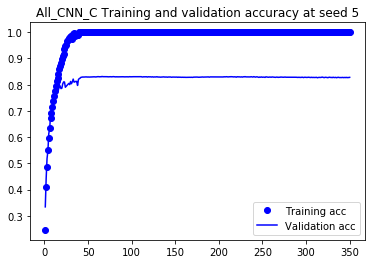

<Figure size 432x288 with 0 Axes>

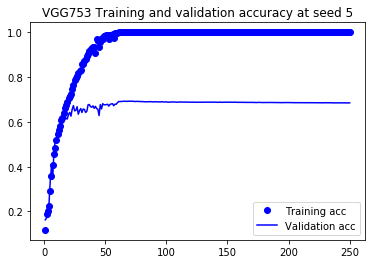

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 6
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 215us/sample - loss: 2.1508 - accuracy: 0.2286 - val_loss: 2.0727 - val_accuracy: 0.2645
Epoch 2/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.8427 - accuracy: 0.3426 - val_loss: 1.6984 - val_accuracy: 0.3832
Epoch 3/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.5855 - accuracy: 0.4271 - val_loss: 1.5622 - val_accuracy: 0.4536
Epoch 4/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.3979 - accuracy: 0.5031 - val_loss: 1.3214 - val_accuracy: 0.5210
Epoch 5/350
50000/50000 [==============================] - 10s 203us/sample - loss: 1.2227 - accuracy: 0.5649 - val_loss: 1.1592 - val_accuracy: 0.5930
Epoch 6/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.0906 - accuracy: 0.6181 - val_loss: 1.0788 - val_accuracy: 0.6244
Epoch 7

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0366 - accuracy: 1.0000 - val_loss: 1.3729 - val_accuracy: 0.8328
Epoch 55/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0366 - accuracy: 1.0000 - val_loss: 1.3790 - val_accuracy: 0.8329
Epoch 56/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0365 - accuracy: 1.0000 - val_loss: 1.3823 - val_accuracy: 0.8335
Epoch 57/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0364 - accuracy: 1.0000 - val_loss: 1.3859 - val_accuracy: 0.8337
Epoch 58/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0364 - accuracy: 1.0000 - val_loss: 1.3889 - val_accuracy: 0.8341
Epoch 59/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0363 - accuracy: 1.0000 - val_loss: 1.3912 - val_accuracy: 0.8336
Epoch 60/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0363 - a

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0313 - accuracy: 1.0000 - val_loss: 1.3418 - val_accuracy: 0.8327
Epoch 161/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0312 - accuracy: 1.0000 - val_loss: 1.3422 - val_accuracy: 0.8328
Epoch 162/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0312 - accuracy: 1.0000 - val_loss: 1.3406 - val_accuracy: 0.8323
Epoch 163/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0311 - accuracy: 1.0000 - val_loss: 1.3413 - val_accuracy: 0.8320
Epoch 164/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0311 - accuracy: 1.0000 - val_loss: 1.3405 - val_accuracy: 0.8322
Epoch 165/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0310 - accuracy: 1.0000 - val_loss: 1.3409 - val_accuracy: 0.8325
Epoch 166/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.03

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0269 - accuracy: 1.0000 - val_loss: 1.3445 - val_accuracy: 0.8295
Epoch 267/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0269 - accuracy: 1.0000 - val_loss: 1.3459 - val_accuracy: 0.8291
Epoch 268/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0269 - accuracy: 1.0000 - val_loss: 1.3468 - val_accuracy: 0.8298
Epoch 269/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0268 - accuracy: 1.0000 - val_loss: 1.3432 - val_accuracy: 0.8299
Epoch 270/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0268 - accuracy: 1.0000 - val_loss: 1.3455 - val_accuracy: 0.8290
Epoch 271/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0268 - accuracy: 1.0000 - val_loss: 1.3475 - val_accuracy: 0.8297
Epoch 272/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.02

50000/50000 [==============================] - 4s 89us/sample - loss: 0.8243 - accuracy: 0.7304 - val_loss: 1.1456 - val_accuracy: 0.6357
Epoch 23/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7684 - accuracy: 0.7516 - val_loss: 1.0808 - val_accuracy: 0.6590
Epoch 24/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7481 - accuracy: 0.7595 - val_loss: 1.0651 - val_accuracy: 0.6613
Epoch 25/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7195 - accuracy: 0.7672 - val_loss: 1.0469 - val_accuracy: 0.6681
Epoch 26/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6639 - accuracy: 0.7900 - val_loss: 1.1253 - val_accuracy: 0.6548
Epoch 27/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6140 - accuracy: 0.8077 - val_loss: 1.2127 - val_accuracy: 0.6430
Epoch 28/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.5853 - accuracy: 0.818

50000/50000 [==============================] - 4s 89us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.3973 - val_accuracy: 0.6854
Epoch 131/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.3961 - val_accuracy: 0.6853
Epoch 132/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.3980 - val_accuracy: 0.6848
Epoch 133/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 3.4009 - val_accuracy: 0.6851
Epoch 134/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 3.4010 - val_accuracy: 0.6846
Epoch 135/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 3.4040 - val_accuracy: 0.6850
Epoch 136/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0719 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.4410 - val_accuracy: 0.6843
Epoch 185/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.4403 - val_accuracy: 0.6842
Epoch 186/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.4403 - val_accuracy: 0.6843
Epoch 187/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.4412 - val_accuracy: 0.6845
Epoch 188/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0704 - accuracy: 1.0000 - val_loss: 3.4417 - val_accuracy: 0.6844
Epoch 189/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0704 - accuracy: 1.0000 - val_loss: 3.4414 - val_accuracy: 0.6844
Epoch 190/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.4405 - val_accuracy: 0.6832
Epoch 239/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.4427 - val_accuracy: 0.6835
Epoch 240/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0690 - accuracy: 1.0000 - val_loss: 3.4410 - val_accuracy: 0.6837
Epoch 241/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0690 - accuracy: 1.0000 - val_loss: 3.4406 - val_accuracy: 0.6841
Epoch 242/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0690 - accuracy: 1.0000 - val_loss: 3.4404 - val_accuracy: 0.6837
Epoch 243/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0690 - accuracy: 1.0000 - val_loss: 3.4408 - val_accuracy: 0.6837
Epoch 244/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.06

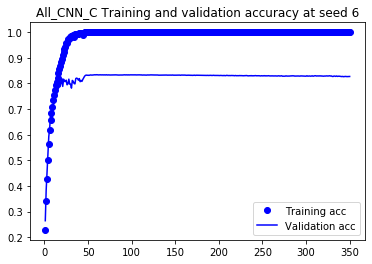

<Figure size 432x288 with 0 Axes>

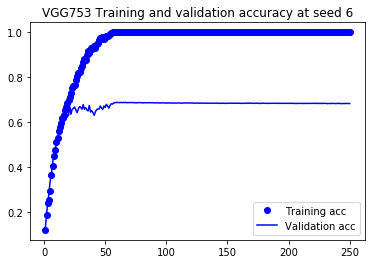

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 7
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 214us/sample - loss: 2.0474 - accuracy: 0.2404 - val_loss: 1.6753 - val_accuracy: 0.3757
Epoch 2/350
50000/50000 [==============================] - 10s 200us/sample - loss: 1.6198 - accuracy: 0.4036 - val_loss: 1.4795 - val_accuracy: 0.4494
Epoch 3/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.4375 - accuracy: 0.4832 - val_loss: 1.3035 - val_accuracy: 0.5461
Epoch 4/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.2849 - accuracy: 0.5446 - val_loss: 1.1537 - val_accuracy: 0.5974
Epoch 5/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.1404 - accuracy: 0.6018 - val_loss: 1.0877 - val_accuracy: 0.6203
Epoch 6/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.0418 - accuracy: 0.6377 - val_loss: 1.0611 - val_accuracy: 0.6298
Epoch 7

50000/50000 [==============================] - 10s 201us/sample - loss: 0.0361 - accuracy: 1.0000 - val_loss: 1.4489 - val_accuracy: 0.8257
Epoch 55/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0360 - accuracy: 1.0000 - val_loss: 1.4508 - val_accuracy: 0.8260
Epoch 56/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0360 - accuracy: 1.0000 - val_loss: 1.4527 - val_accuracy: 0.8260
Epoch 57/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0359 - accuracy: 1.0000 - val_loss: 1.4541 - val_accuracy: 0.8261
Epoch 58/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.4555 - val_accuracy: 0.8262
Epoch 59/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.4554 - val_accuracy: 0.8264
Epoch 60/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0357 - a

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.3877 - val_accuracy: 0.8255
Epoch 161/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.3862 - val_accuracy: 0.8250
Epoch 162/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0307 - accuracy: 1.0000 - val_loss: 1.3869 - val_accuracy: 0.8251
Epoch 163/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0307 - accuracy: 1.0000 - val_loss: 1.3853 - val_accuracy: 0.8248
Epoch 164/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0306 - accuracy: 1.0000 - val_loss: 1.3851 - val_accuracy: 0.8248
Epoch 165/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0306 - accuracy: 1.0000 - val_loss: 1.3845 - val_accuracy: 0.8256
Epoch 166/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.03

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.3829 - val_accuracy: 0.8238
Epoch 267/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3831 - val_accuracy: 0.8230
Epoch 268/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3838 - val_accuracy: 0.8236
Epoch 269/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3839 - val_accuracy: 0.8230
Epoch 270/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0264 - accuracy: 1.0000 - val_loss: 1.3882 - val_accuracy: 0.8233
Epoch 271/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0264 - accuracy: 1.0000 - val_loss: 1.3839 - val_accuracy: 0.8233
Epoch 272/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.02

50000/50000 [==============================] - 4s 89us/sample - loss: 0.8250 - accuracy: 0.7289 - val_loss: 1.1511 - val_accuracy: 0.6341
Epoch 23/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7809 - accuracy: 0.7464 - val_loss: 1.1023 - val_accuracy: 0.6562
Epoch 24/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7277 - accuracy: 0.7668 - val_loss: 1.0905 - val_accuracy: 0.6566
Epoch 25/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7106 - accuracy: 0.7743 - val_loss: 1.1632 - val_accuracy: 0.6337
Epoch 26/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6823 - accuracy: 0.7845 - val_loss: 1.1035 - val_accuracy: 0.6656
Epoch 27/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6228 - accuracy: 0.8046 - val_loss: 1.0781 - val_accuracy: 0.6760
Epoch 28/250
50000/50000 [==============================] - 4s 88us/sample - loss: 0.5824 - accuracy: 0.820

50000/50000 [==============================] - 4s 90us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.4710 - val_accuracy: 0.6861
Epoch 131/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0721 - accuracy: 1.0000 - val_loss: 3.4702 - val_accuracy: 0.6863
Epoch 132/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.4717 - val_accuracy: 0.6861
Epoch 133/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.4743 - val_accuracy: 0.6863
Epoch 134/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.4758 - val_accuracy: 0.6859
Epoch 135/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0720 - accuracy: 1.0000 - val_loss: 3.4768 - val_accuracy: 0.6858
Epoch 136/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0719 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.5056 - val_accuracy: 0.6851
Epoch 185/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.5057 - val_accuracy: 0.6848
Epoch 186/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0706 - accuracy: 1.0000 - val_loss: 3.5051 - val_accuracy: 0.6853
Epoch 187/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.5058 - val_accuracy: 0.6850
Epoch 188/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.5053 - val_accuracy: 0.6854
Epoch 189/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.5060 - val_accuracy: 0.6851
Epoch 190/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.5004 - val_accuracy: 0.6838
Epoch 239/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.4988 - val_accuracy: 0.6836
Epoch 240/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.5004 - val_accuracy: 0.6842
Epoch 241/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.4987 - val_accuracy: 0.6835
Epoch 242/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0691 - accuracy: 1.0000 - val_loss: 3.4988 - val_accuracy: 0.6836
Epoch 243/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0690 - accuracy: 1.0000 - val_loss: 3.4988 - val_accuracy: 0.6836
Epoch 244/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.06

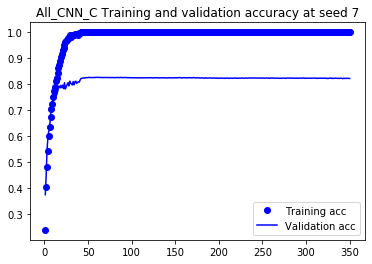

<Figure size 432x288 with 0 Axes>

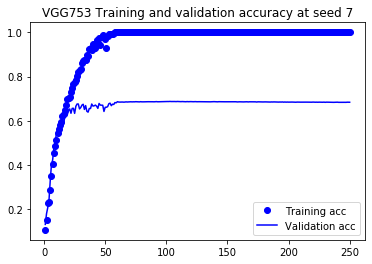

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 8
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 222us/sample - loss: 2.0148 - accuracy: 0.2516 - val_loss: 1.8409 - val_accuracy: 0.3424
Epoch 2/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.6444 - accuracy: 0.3990 - val_loss: 1.5337 - val_accuracy: 0.4401
Epoch 3/350
50000/50000 [==============================] - 10s 200us/sample - loss: 1.4208 - accuracy: 0.4894 - val_loss: 1.2885 - val_accuracy: 0.5396
Epoch 4/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.2537 - accuracy: 0.5538 - val_loss: 1.1429 - val_accuracy: 0.5927
Epoch 5/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.1255 - accuracy: 0.6049 - val_loss: 1.0575 - val_accuracy: 0.6187
Epoch 6/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.0028 - accuracy: 0.6521 - val_loss: 1.0502 - val_accuracy: 0.6201
Epoch 7

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0361 - accuracy: 1.0000 - val_loss: 1.4109 - val_accuracy: 0.8239
Epoch 55/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0361 - accuracy: 1.0000 - val_loss: 1.4126 - val_accuracy: 0.8241
Epoch 56/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0360 - accuracy: 1.0000 - val_loss: 1.4151 - val_accuracy: 0.8241
Epoch 57/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0360 - accuracy: 1.0000 - val_loss: 1.4172 - val_accuracy: 0.8238
Epoch 58/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0359 - accuracy: 1.0000 - val_loss: 1.4174 - val_accuracy: 0.8247
Epoch 59/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0359 - accuracy: 1.0000 - val_loss: 1.4183 - val_accuracy: 0.8238
Epoch 60/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0358 - a

50000/50000 [==============================] - 10s 203us/sample - loss: 0.0309 - accuracy: 1.0000 - val_loss: 1.3733 - val_accuracy: 0.8251
Epoch 161/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0309 - accuracy: 1.0000 - val_loss: 1.3736 - val_accuracy: 0.8258
Epoch 162/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.3742 - val_accuracy: 0.8255
Epoch 163/350
50000/50000 [==============================] - 10s 204us/sample - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.3728 - val_accuracy: 0.8255
Epoch 164/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0307 - accuracy: 1.0000 - val_loss: 1.3707 - val_accuracy: 0.8256
Epoch 165/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0307 - accuracy: 1.0000 - val_loss: 1.3725 - val_accuracy: 0.8254
Epoch 166/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.03

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0267 - accuracy: 1.0000 - val_loss: 1.3958 - val_accuracy: 0.8213
Epoch 267/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.3943 - val_accuracy: 0.8223
Epoch 268/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.3951 - val_accuracy: 0.8230
Epoch 269/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.3970 - val_accuracy: 0.8224
Epoch 270/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3958 - val_accuracy: 0.8221
Epoch 271/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0265 - accuracy: 1.0000 - val_loss: 1.3958 - val_accuracy: 0.8231
Epoch 272/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.02

50000/50000 [==============================] - 4s 89us/sample - loss: 0.8284 - accuracy: 0.7304 - val_loss: 1.0799 - val_accuracy: 0.6530
Epoch 23/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7957 - accuracy: 0.7411 - val_loss: 1.0918 - val_accuracy: 0.6522
Epoch 24/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7638 - accuracy: 0.7542 - val_loss: 1.1085 - val_accuracy: 0.6499
Epoch 25/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.7105 - accuracy: 0.7740 - val_loss: 1.0779 - val_accuracy: 0.6701
Epoch 26/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6802 - accuracy: 0.7838 - val_loss: 1.0868 - val_accuracy: 0.6714
Epoch 27/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6352 - accuracy: 0.7979 - val_loss: 1.1450 - val_accuracy: 0.6464
Epoch 28/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6021 - accuracy: 0.813

50000/50000 [==============================] - 4s 89us/sample - loss: 0.0724 - accuracy: 1.0000 - val_loss: 3.3384 - val_accuracy: 0.6900
Epoch 131/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3397 - val_accuracy: 0.6900
Epoch 132/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3412 - val_accuracy: 0.6897
Epoch 133/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3419 - val_accuracy: 0.6894
Epoch 134/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.3425 - val_accuracy: 0.6896
Epoch 135/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.3437 - val_accuracy: 0.6897
Epoch 136/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0709 - accuracy: 1.0000 - val_loss: 3.3684 - val_accuracy: 0.6897
Epoch 185/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3687 - val_accuracy: 0.6896
Epoch 186/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3689 - val_accuracy: 0.6900
Epoch 187/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3687 - val_accuracy: 0.6895
Epoch 188/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.3693 - val_accuracy: 0.6893
Epoch 189/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.3690 - val_accuracy: 0.6893
Epoch 190/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3575 - val_accuracy: 0.6887
Epoch 239/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.3572 - val_accuracy: 0.6882
Epoch 240/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3575 - val_accuracy: 0.6887
Epoch 241/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3562 - val_accuracy: 0.6885
Epoch 242/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3557 - val_accuracy: 0.6881
Epoch 243/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.3552 - val_accuracy: 0.6883
Epoch 244/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.06

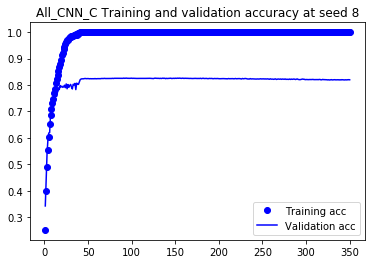

<Figure size 432x288 with 0 Axes>

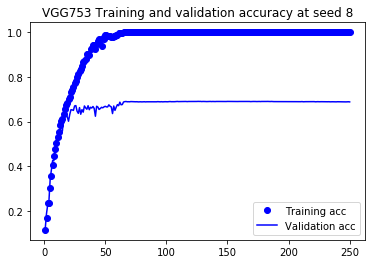

<Figure size 432x288 with 0 Axes>

Training All_CNN_C with seed 9
Train on 50000 samples, validate on 10000 samples
Epoch 1/350
50000/50000 [==============================] - 11s 214us/sample - loss: 2.2113 - accuracy: 0.1906 - val_loss: 2.0492 - val_accuracy: 0.2779
Epoch 2/350
50000/50000 [==============================] - 10s 201us/sample - loss: 1.8068 - accuracy: 0.3469 - val_loss: 1.5779 - val_accuracy: 0.4191
Epoch 3/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.5280 - accuracy: 0.4483 - val_loss: 1.4773 - val_accuracy: 0.4569
Epoch 4/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.3562 - accuracy: 0.5172 - val_loss: 1.2595 - val_accuracy: 0.5492
Epoch 5/350
50000/50000 [==============================] - 10s 202us/sample - loss: 1.2152 - accuracy: 0.5715 - val_loss: 1.1163 - val_accuracy: 0.6104
Epoch 6/350
50000/50000 [==============================] - 10s 200us/sample - loss: 1.1029 - accuracy: 0.6167 - val_loss: 1.0688 - val_accuracy: 0.6267
Epoch 7

50000/50000 [==============================] - 10s 201us/sample - loss: 0.0365 - accuracy: 1.0000 - val_loss: 1.5170 - val_accuracy: 0.8155
Epoch 55/350
50000/50000 [==============================] - 10s 200us/sample - loss: 0.0364 - accuracy: 1.0000 - val_loss: 1.5216 - val_accuracy: 0.8148
Epoch 56/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0364 - accuracy: 1.0000 - val_loss: 1.5267 - val_accuracy: 0.8150
Epoch 57/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0363 - accuracy: 1.0000 - val_loss: 1.5291 - val_accuracy: 0.8150
Epoch 58/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0362 - accuracy: 1.0000 - val_loss: 1.5332 - val_accuracy: 0.8150
Epoch 59/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0362 - accuracy: 1.0000 - val_loss: 1.5357 - val_accuracy: 0.8154
Epoch 60/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0361 - a

50000/50000 [==============================] - 10s 202us/sample - loss: 0.0311 - accuracy: 1.0000 - val_loss: 1.4742 - val_accuracy: 0.8169
Epoch 161/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0311 - accuracy: 1.0000 - val_loss: 1.4746 - val_accuracy: 0.8174
Epoch 162/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0310 - accuracy: 1.0000 - val_loss: 1.4741 - val_accuracy: 0.8169
Epoch 163/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0310 - accuracy: 1.0000 - val_loss: 1.4732 - val_accuracy: 0.8170
Epoch 164/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0309 - accuracy: 1.0000 - val_loss: 1.4746 - val_accuracy: 0.8163
Epoch 165/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0309 - accuracy: 1.0000 - val_loss: 1.4734 - val_accuracy: 0.8167
Epoch 166/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.03

50000/50000 [==============================] - 10s 201us/sample - loss: 0.0268 - accuracy: 1.0000 - val_loss: 1.4781 - val_accuracy: 0.8153
Epoch 267/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0267 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.8145
Epoch 268/350
50000/50000 [==============================] - 10s 203us/sample - loss: 0.0267 - accuracy: 1.0000 - val_loss: 1.4784 - val_accuracy: 0.8154
Epoch 269/350
50000/50000 [==============================] - 10s 201us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.4724 - val_accuracy: 0.8148
Epoch 270/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.4763 - val_accuracy: 0.8164
Epoch 271/350
50000/50000 [==============================] - 10s 202us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.4796 - val_accuracy: 0.8146
Epoch 272/350
50000/50000 [==============================] - 10s 200us/sample - loss: 0.02

50000/50000 [==============================] - 4s 90us/sample - loss: 0.8475 - accuracy: 0.7242 - val_loss: 1.0966 - val_accuracy: 0.6476
Epoch 23/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.8197 - accuracy: 0.7341 - val_loss: 1.1449 - val_accuracy: 0.6387
Epoch 24/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.7737 - accuracy: 0.7509 - val_loss: 1.0539 - val_accuracy: 0.6603
Epoch 25/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7596 - accuracy: 0.7554 - val_loss: 1.1920 - val_accuracy: 0.6366
Epoch 26/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.7021 - accuracy: 0.7740 - val_loss: 1.0896 - val_accuracy: 0.6615
Epoch 27/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.6821 - accuracy: 0.7822 - val_loss: 1.0754 - val_accuracy: 0.6646
Epoch 28/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6359 - accuracy: 0.797

50000/50000 [==============================] - 4s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.2351 - val_accuracy: 0.6905
Epoch 131/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.2345 - val_accuracy: 0.6908
Epoch 132/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0723 - accuracy: 1.0000 - val_loss: 3.2366 - val_accuracy: 0.6909
Epoch 133/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2386 - val_accuracy: 0.6907
Epoch 134/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2393 - val_accuracy: 0.6912
Epoch 135/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0722 - accuracy: 1.0000 - val_loss: 3.2398 - val_accuracy: 0.6909
Epoch 136/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0721 - accuracy:

Epoch 184/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.2639 - val_accuracy: 0.6911
Epoch 185/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.2643 - val_accuracy: 0.6905
Epoch 186/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0708 - accuracy: 1.0000 - val_loss: 3.2648 - val_accuracy: 0.6907
Epoch 187/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2641 - val_accuracy: 0.6910
Epoch 188/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2642 - val_accuracy: 0.6903
Epoch 189/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0707 - accuracy: 1.0000 - val_loss: 3.2648 - val_accuracy: 0.6909
Epoch 190/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.07

Epoch 238/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0694 - accuracy: 1.0000 - val_loss: 3.2552 - val_accuracy: 0.6902
Epoch 239/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.2546 - val_accuracy: 0.6900
Epoch 240/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.2538 - val_accuracy: 0.6903
Epoch 241/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0693 - accuracy: 1.0000 - val_loss: 3.2539 - val_accuracy: 0.6902
Epoch 242/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.2537 - val_accuracy: 0.6904
Epoch 243/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0692 - accuracy: 1.0000 - val_loss: 3.2538 - val_accuracy: 0.6905
Epoch 244/250
50000/50000 [==============================] - 4s 89us/sample - loss: 0.06

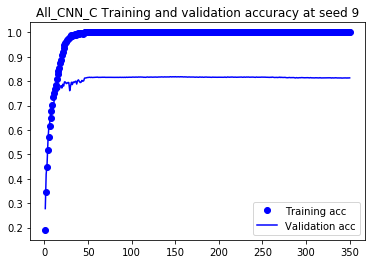

<Figure size 432x288 with 0 Axes>

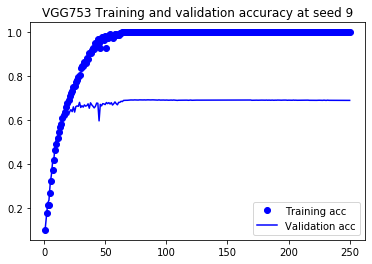

<Figure size 432x288 with 0 Axes>

In [4]:
train_primary()

In [ ]:
def train_secondary():
    
    for 

In [3]:
# Testing cell

K.clear_session()
# Unsure if samplewise_std_normalization is equivalent to GCN
'''
USE TENSORFLOW INSTEAD OF KERAS FOR DATA GEN
trainData = tf.data.Dataset.from_tensor_slices((x_train, y_train))
To run just a single gpu: set CUDA_VISIBLE_DEVICES 1 in environment var
'''
train_datagen = ImageDataGenerator(zca_whitening=True,
                                   samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(zca_whitening=True,
                                  samplewise_std_normalization=True)
train_datagen.fit(x_train)
test_datagen.fit(x_test)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=50000,
)
train_new = train_generator[0]
print('Getting x_train_new')
x_train_new = train_new[0]
print('Getting y_train_new')
y_train_new = train_new[1]
test_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=10000
)
test_new = test_generator[0]
print('Getting x_test_new')
x_test_new = test_new[0]
print('Getting y_test_new')
y_test_new = test_new[1]
def scheduler(epoch, lr):
    if (epoch == 200 or epoch == 250 or epoch == 300):
        return lr * 0.1
    return lr

def scheduler_v(epoch, lr):
    if (epoch == 125 or epoch == 175 or epoch == 225):
        return lr * 0.1
    return lr
    
callback = LearningRateScheduler(scheduler)
# print('Training All_CNN_C with seed', str(1))
# a_history = all_cnn_c.fit(
#             x_train_new,
#             y_train_new,
#             batch_size=128,
#             epochs=350,
#             callbacks=[callback],
#             validation_data=(x_test_new, y_test_new))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Getting x_train_new
Getting y_train_new
Getting x_test_new
Getting y_test_new


In [5]:
print('Training VGG753 with seed', str(1))
K.clear_session()
vgg753 = init_model('vgg753', seed=1)
callback = LearningRateScheduler(scheduler_v)
history = vgg753.fit(
            x_train_new,
            y_train_new,
            batch_size=512,
            epochs=250,
            callbacks=[callback],
            validation_data=(x_test_new, y_test_new))

Training VGG753 with seed 1
Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 [==============================] - 5s 108us/sample - loss: 2.3736 - accuracy: 0.1046 - val_loss: 2.3731 - val_accuracy: 0.1005
Epoch 2/250
50000/50000 [==============================] - 4s 90us/sample - loss: 2.3721 - accuracy: 0.1167 - val_loss: 2.3717 - val_accuracy: 0.1113
Epoch 3/250
50000/50000 [==============================] - 5s 91us/sample - loss: 2.3700 - accuracy: 0.1255 - val_loss: 2.3691 - val_accuracy: 0.1287
Epoch 4/250
50000/50000 [==============================] - 4s 90us/sample - loss: 2.3643 - accuracy: 0.1533 - val_loss: 2.3606 - val_accuracy: 0.1695
Epoch 5/250
50000/50000 [==============================] - 5s 91us/sample - loss: 2.3205 - accuracy: 0.1841 - val_loss: 2.2284 - val_accuracy: 0.1925
Epoch 6/250
50000/50000 [==============================] - 5s 90us/sample - loss: 2.1985 - accuracy: 0.1888 - val_loss: 2.0956 - val_accuracy: 0.2072
Epoch 7/250
50000/500

Epoch 55/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0821 - accuracy: 0.9978 - val_loss: 4.2255 - val_accuracy: 0.5426
Epoch 56/250
50000/50000 [==============================] - 5s 93us/sample - loss: 0.0770 - accuracy: 0.9995 - val_loss: 4.3239 - val_accuracy: 0.5487
Epoch 57/250
50000/50000 [==============================] - 5s 94us/sample - loss: 0.0745 - accuracy: 1.0000 - val_loss: 4.5019 - val_accuracy: 0.5479
Epoch 58/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0741 - accuracy: 1.0000 - val_loss: 4.6162 - val_accuracy: 0.5495
Epoch 59/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0740 - accuracy: 1.0000 - val_loss: 4.6806 - val_accuracy: 0.5480
Epoch 60/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0740 - accuracy: 1.0000 - val_loss: 4.7283 - val_accuracy: 0.5479
Epoch 61/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0739 - ac

Epoch 163/250
50000/50000 [==============================] - 4s 90us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 5.4449 - val_accuracy: 0.5424
Epoch 164/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 5.4451 - val_accuracy: 0.5424
Epoch 165/250
50000/50000 [==============================] - 5s 92us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 5.4453 - val_accuracy: 0.5424
Epoch 166/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 5.4457 - val_accuracy: 0.5424
Epoch 167/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 5.4459 - val_accuracy: 0.5424
Epoch 168/250
50000/50000 [==============================] - 5s 92us/sample - loss: 0.0719 - accuracy: 1.0000 - val_loss: 5.4461 - val_accuracy: 0.5424
Epoch 169/250
50000/50000 [==============================] - 5s 91us/sample - loss: 0.07

Epoch 217/250
50000/50000 [==============================] - 5s 93us/sample - loss: 0.0718 - accuracy: 1.0000 - val_loss: 5.4492 - val_accuracy: 0.5424
Epoch 218/250
50000/50000 [==============================] - 5s 94us/sample - loss: 0.0718 - accuracy: 1.0000 - val_loss: 5.4493 - val_accuracy: 0.5424
Epoch 219/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0718 - accuracy: 1.0000 - val_loss: 5.4493 - val_accuracy: 0.5424
Epoch 220/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0718 - accuracy: 1.0000 - val_loss: 5.4493 - val_accuracy: 0.5424
Epoch 221/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0718 - accuracy: 1.0000 - val_loss: 5.4494 - val_accuracy: 0.5424
Epoch 222/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.0718 - accuracy: 1.0000 - val_loss: 5.4494 - val_accuracy: 0.5424
Epoch 223/250
50000/50000 [==============================] - 5s 90us/sample - loss: 0.07

In [ ]:
print('Training All_Cnn_C with seed', str(1))
K.clear_session()
vgg753 = init_model('all_cnn_c', seed=1)
callback = LearningRateScheduler(scheduler_v)
history = vgg753.fit(
            x_train_new,
            y_train_new,
            batch_size=128,
            epochs=250,
            callbacks=[callback],
            validation_data=(x_test_new, y_test_new))